In [1]:
%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import dicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt
import SimpleITK

In [2]:
def load_itk(mhd_filepath):
    """
    This function reads a '.mhd' file using SimpleITK and return the image array,
    origin and spacing of the image.
    :param mhd_filepath:
    :return:
    """

    # Reads the image using SimpleITK
    itk_image = SimpleITK.ReadImage(mhd_filepath)

    # Convert the image to a  numpy array first and then shuffle the
    # dimensions to get axis in the order z,y,x
    ct_scan = SimpleITK.GetArrayFromImage(itk_image)

    # Read the origin of the ct_scan, will be used to convert the coordinates
    # from world to voxel and vice versa.
    origin = np.array(list(reversed(itk_image.GetOrigin())))

    # Read the spacing along each dimension
    spacing = np.array(list(reversed(itk_image.GetSpacing())))

    return ct_scan, origin, spacing

In [13]:
img, origin, spacing = load_itk("1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016233746780170740405.mhd")

In [5]:
len(ct_scan)

321

In [7]:
annotations = pd.read_csv("annotations.csv")

In [11]:
candidates=annotations[annotations["seriesuid"]=="1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016233746780170740405"]

In [14]:
# calculate resize factor
resize_spacing = [1, 1, 1]
resize_factor = spacing / resize_spacing
new_real_shape = img.shape * resize_factor
new_shape = np.round(new_real_shape)
real_resize = new_shape / img.shape
new_spacing = spacing / real_resize

In [15]:
lung_img = scipy.ndimage.interpolation.zoom(img, real_resize)

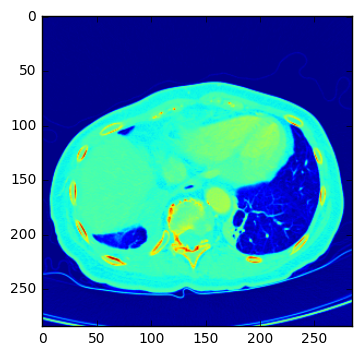

In [19]:
plt.imshow(lung_img[100])

In [21]:
def draw_circles(image, candidates, origin, spacing):
    """
    This function is used to create spherical regions in binary masks
    at the given locations and radius.
    """

    # make empty matrix, which will be filled with the mask
    resize_spacing = [1, 1, 1]
    image_mask = np.zeros(image.shape)

    # run over all the nodules in the lungs
    for candidate in candidates.values:
        # get middle x-,y-, and z-world_coordinate of the nodule
        radius = np.ceil(candidate[4]) / 2
        coord_x = candidate[1]
        coord_y = candidate[2]
        coord_z = candidate[3]
        image_coord = np.array((coord_z, coord_y, coord_x))

        # determine voxel coordinate given the world_coordinate
        image_coord = world_2_voxel(image_coord, origin, spacing)

        # determine the range of the nodule
        nodule_range = seq(-radius, radius, resize_spacing[0])

        # create the mask
        for x in nodule_range:
            for y in nodule_range:
                for z in nodule_range:
                    world_coordinates = np.array((coord_z + z, coord_y + y, coord_x + x))
                    coordinates = world_2_voxel(world_coordinates, origin, spacing)
                    if (np.linalg.norm(image_coord - coordinates) * resize_spacing[0]) < radius:
                        rx = np.round(coordinates[0])
                        ry = np.round(coordinates[1])
                        rz = np.round(coordinates[2])
                        image_mask[rx, ry, rz] = int(1)
    return image_mask

In [26]:
nodule_mask = draw_circles(lung_img, candidates, origin, new_spacing)

/Users/um003282/.pyenv/versions/3.5.2/lib/python3.5/site-packages/ipykernel/__main__.py:36: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [23]:
def world_2_voxel(world_coordinates, origin, spacing):
    """
    This function is used to convert the world coordinates to voxel coordinates using 
    the origin and spacing of the ct_scan
    """

    stretched_voxel_coordinates = np.absolute(world_coordinates - origin)
    voxel_coordinates = stretched_voxel_coordinates / spacing
    return voxel_coordinates

In [25]:
def seq(start, stop, step=1):
    n = int(round((stop - start) / float(step)))
    if n > 1:
        return [start + step * i for i in range(n + 1)]
    else:
        return []

In [28]:
len(nodule_mask)

321

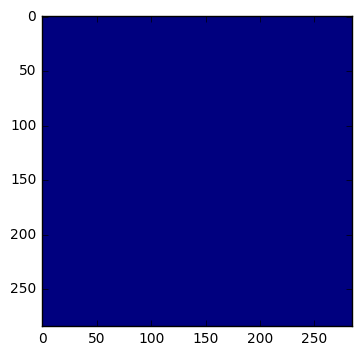

In [29]:
plt.imshow(nodule_mask[100])

In [41]:
def part_plot(images, nodules, num):
    part = len(images) // num
    f, plots = plt.subplots(num, 2, figsize=(5, 40))
    idx = [i * part for i in range(num)]
    print(idx)
    for i in range(num):
        plots[i, 0].axis('off')
        plots[i, 0].imshow(images[idx[i]], cmap=plt.cm.bone) 
        plots[i, 1].axis('off')
        plots[i, 1].imshow(nodules[idx[i]], cmap=plt.cm.bone) 

[0, 32, 64, 96, 128, 160, 192, 224, 256, 288]


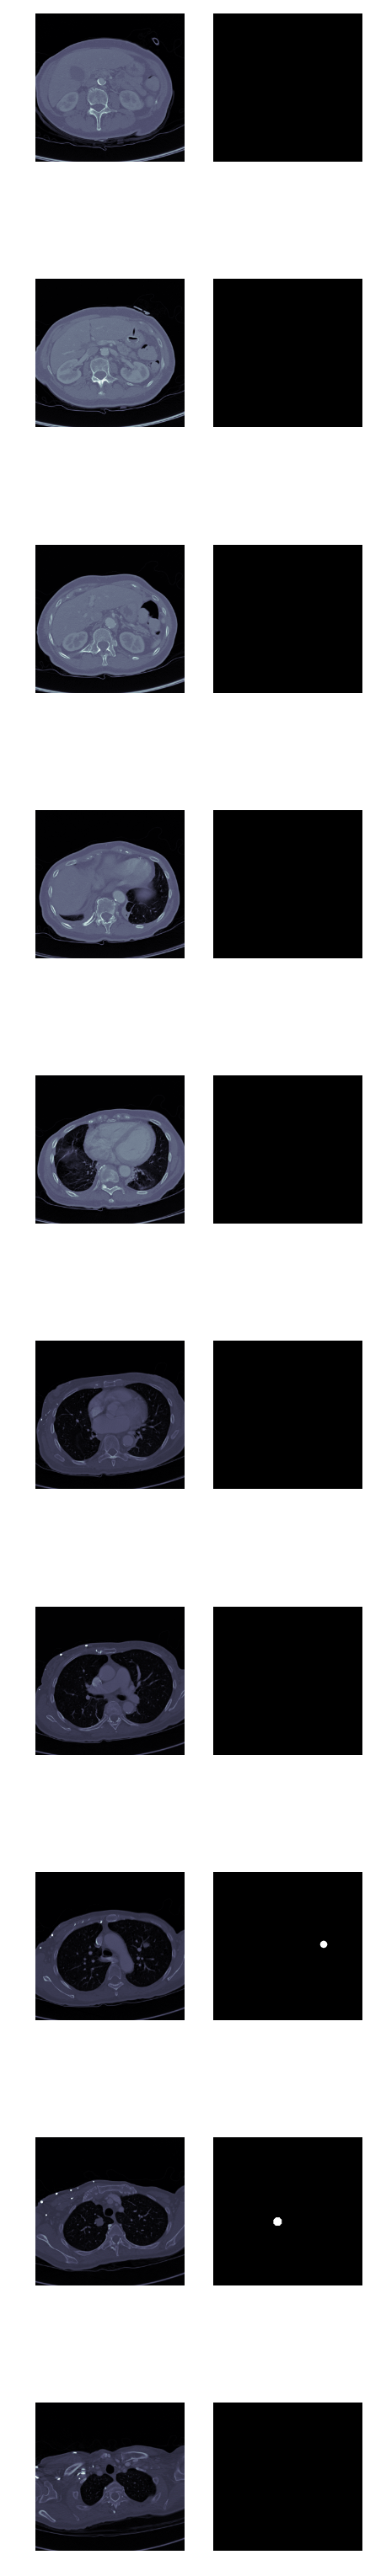

In [42]:
part_plot(lung_img, nodule_mask, 10)